Available columns: ['Customer ID', 'Month', 'Month of Joining', 'zip_code', 'Gender', 'Age', 'Married', 'Dependents', 'Number of Dependents', 'Location ID', 'Service ID', 'state', 'county', 'timezone', 'area_codes', 'country', 'latitude', 'longitude', 'roam_ic', 'roam_og', 'loc_og_t2t', 'loc_og_t2m', 'loc_og_t2f', 'loc_og_t2c', 'std_og_t2t', 'std_og_t2m', 'std_og_t2f', 'std_og_t2c', 'isd_og', 'spl_og', 'og_others', 'loc_ic_t2t', 'loc_ic_t2m', 'loc_ic_t2f', 'std_ic_t2t', 'std_ic_t2m', 'std_ic_t2f', 'std_ic_t2o', 'spl_ic', 'isd_ic', 'ic_others', 'total_rech_amt', 'total_rech_data', 'vol_4g', 'vol_5g', 'arpu_5g', 'arpu_4g', 'arpu', 'night_pck_user', 'fb_user', 'aug_vbc_5g', 'offer', 'Referred a Friend', 'Number of Referrals', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Streaming Data Consumption', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Payme

<Figure size 640x480 with 0 Axes>

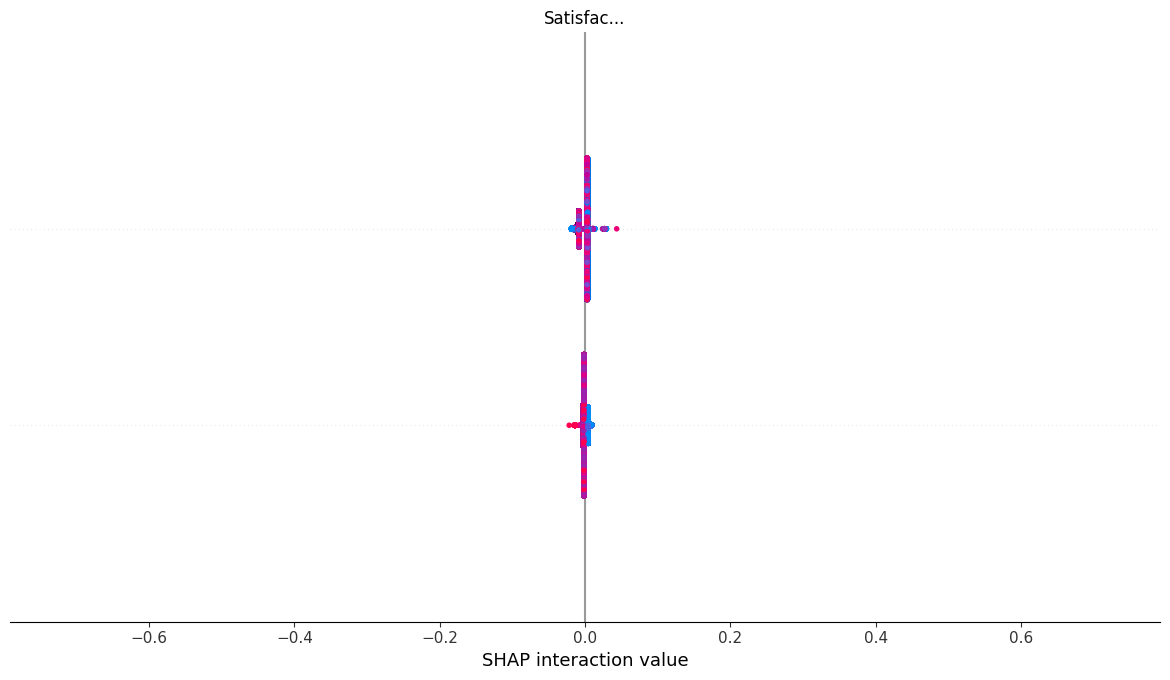

Recommended service for customer 29497: Service ID    43880
Service ID    43880
Name: 0, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import RFECV, VarianceThreshold

# Load the Dataset
path = '/content/drive/MyDrive/dataset/t_mobil.csv'
df = pd.read_csv(path)

# Print available columns
print("Available columns:", df.columns.tolist())

# Ensure important columns exist
important_cols = ['Customer ID', 'Service ID', 'Churn Value']
for col in important_cols:
    if col not in df.columns:
        raise KeyError(f"Missing important column: {col}")

# Drop unnecessary columns
if 'county' in df.columns:
    df.drop(columns=['county'], inplace=True)
    print("Dropped 'county' column.")

# Identify categorical columns (excluding Customer ID)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['Customer ID']]

# Convert categorical columns using Label Encoding
label_encoders = {}
for col in categorical_cols:
    df[col] = df[col].astype(str)  # Ensure data is in string format
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders

# Apply Variance Threshold
X_numeric = df.drop(columns=['Churn Value', 'Customer ID'], errors='ignore')
var_thresh = VarianceThreshold(threshold=0.01)  # Remove low-variance features
X_var = var_thresh.fit_transform(X_numeric)
selected_cols = X_numeric.columns[var_thresh.get_support()]
df = df[selected_cols.tolist() + important_cols]
print(f"Remaining Features after Variance Threshold: {df.columns.tolist()}")

# Fill missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Define X and y
X = df.drop(columns=['Churn Value', 'Customer ID', 'Service ID'])
y = df['Churn Value']

# Reduce RF complexity
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)

# Handle high-cardinality categorical variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
high_card_cols = [col for col in categorical_cols if df[col].nunique(dropna=True) > 50]
for col in high_card_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Subset data for faster processing
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=min(20000, len(X)), stratify=y, random_state=42)

# Feature selection using RFECV
rfe = RFECV(estimator=rf_model, step=2, min_features_to_select=5, cv=3, n_jobs=-1)
rfe.fit(X_sample, y_sample)
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

# Train RF model and perform SHAP analysis
rf_model.fit(X[selected_features], y)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X[selected_features])
shap.summary_plot(shap_values, X[selected_features])

# Normalize data for similarity calculations
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[selected_features])

# Train Nearest Neighbors model
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(X_scaled)

# Recommend Services Function
def recommend_service(customer_id):
    if customer_id not in df['Customer ID'].values:
        raise ValueError(f"Customer ID {customer_id} not found.")

    customer_index = df.index[df['Customer ID'] == customer_id].tolist()[0]
    customer_data = X_scaled[customer_index].reshape(1, -1)
    distances, indices = knn.kneighbors(customer_data)

    recommended_services = df.iloc[indices[0]]['Service ID'].mode()
    return recommended_services.iloc[0] if not recommended_services.empty else "No recommendation available"

# Example: Get recommendation for a sample customer
sample_customer = df['Customer ID'].iloc[0]
print(f"Recommended service for customer {sample_customer}: {recommend_service(sample_customer)}")


# New Section

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import RFECV, VarianceThreshold

# Load the Dataset
path = '/content/drive/MyDrive/dataset/t_mobil.csv'
df = pd.read_csv(path)

# Print available columns
print("Available columns:", df.columns.tolist())

# Ensure important columns exist
important_cols = ['Customer ID', 'Service ID', 'Churn Value']
for col in important_cols:
    if col not in df.columns:
        raise KeyError(f"Missing important column: {col}")

# Drop unnecessary columns
if 'county' in df.columns:
    df.drop(columns=['county'], inplace=True)
    print("Dropped 'county' column.")

# Identify categorical columns (excluding Customer ID)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['Customer ID']]

# Convert categorical columns using Label Encoding
label_encoders = {}
for col in categorical_cols:
    df[col] = df[col].astype(str)  # Ensure data is in string format
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders

# Apply Variance Threshold
X_numeric = df.drop(columns=['Churn Value', 'Customer ID'], errors='ignore')
var_thresh = VarianceThreshold(threshold=0.01)  # Remove low-variance features
X_var = var_thresh.fit_transform(X_numeric)
selected_cols = X_numeric.columns[var_thresh.get_support()]
df = df[selected_cols.tolist() + important_cols]
print(f"Remaining Features after Variance Threshold: {df.columns.tolist()}")

# Fill missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Define X and y
X = df.drop(columns=['Churn Value', 'Customer ID', 'Service ID'])
y = df['Churn Value']

# Reduce RF complexity
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)

# Handle high-cardinality categorical variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
high_card_cols = [col for col in categorical_cols if df[col].nunique(dropna=True) > 50]
for col in high_card_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Subset data for faster processing
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=min(20000, len(X)), stratify=y, random_state=42)

# Feature selection using RFECV
rfe = RFECV(estimator=rf_model, step=2, min_features_to_select=5, cv=3, n_jobs=-1)
rfe.fit(X_sample, y_sample)
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

# Train RF model and perform SHAP analysis
rf_model.fit(X[selected_features], y)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X[selected_features])

# Normalize data for similarity calculations
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[selected_features])

# Train Nearest Neighbors model
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(X_scaled)

# Recommend Services Function
def recommend_service(customer_id):
    if customer_id not in df['Customer ID'].values:
        return f"Customer ID {customer_id} not found. Please try again."

    customer_index = df.index[df['Customer ID'] == customer_id].tolist()[0]
    customer_data = X_scaled[customer_index].reshape(1, -1)
    distances, indices = knn.kneighbors(customer_data)

    recommended_services = df.iloc[indices[0]]['Service ID'].mode()
    return recommended_services.iloc[0] if not recommended_services.empty else "No recommendation available"

# Ask user for Customer ID and recommend a service
customer_id_input = input("Enter Customer ID: ")
try:
    customer_id_input = int(customer_id_input)
    recommendation = recommend_service(customer_id_input)
    print(f"Recommended service for customer {customer_id_input}: {recommendation}")
except ValueError:
    print("Invalid input. Please enter a numeric Customer ID.")


Available columns: ['Customer ID', 'Month', 'Month of Joining', 'zip_code', 'Gender', 'Age', 'Married', 'Dependents', 'Number of Dependents', 'Location ID', 'Service ID', 'state', 'county', 'timezone', 'area_codes', 'country', 'latitude', 'longitude', 'roam_ic', 'roam_og', 'loc_og_t2t', 'loc_og_t2m', 'loc_og_t2f', 'loc_og_t2c', 'std_og_t2t', 'std_og_t2m', 'std_og_t2f', 'std_og_t2c', 'isd_og', 'spl_og', 'og_others', 'loc_ic_t2t', 'loc_ic_t2m', 'loc_ic_t2f', 'std_ic_t2t', 'std_ic_t2m', 'std_ic_t2f', 'std_ic_t2o', 'spl_ic', 'isd_ic', 'ic_others', 'total_rech_amt', 'total_rech_data', 'vol_4g', 'vol_5g', 'arpu_5g', 'arpu_4g', 'arpu', 'night_pck_user', 'fb_user', 'aug_vbc_5g', 'offer', 'Referred a Friend', 'Number of Referrals', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Streaming Data Consumption', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Payme